### **IMAGE CLASSIFICATION USING CIFAR-10 DATASET: A COMPARISON OF MANHATTAN (L1) AND EUCLIDEAN (L2) DISTANCES WITH 5-FOLD CROSS-VALIDATION**

The code implements a K-Nearest Neighbors (KNN) algorithm for image classification. It calculates L1 and L2 distances between images in a `training set` and a `validation set`, finds the nearest neighbors for each validation image, and then predicts the class of the validation image based on the classes of its nearest neighbors.

In [1]:
import os                                   # File and directory operation
import random                               # Randomizing data
import cv2 as cv                            # OpenCV for image processing
from tqdm import tqdm                       # Displaying progress bar
import numpy as np                          # Numerical opeation
import matplotlib.pyplot as plt             # Plotting
from IPython import get_ipython
import nbformat
from PIL import Image                       # Image processing
import math

In [2]:
# Version Check
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


### **Dataset and Preprocessing:**

`TRAIN_DIR` specifies the directory containing training data. `CATEGORIES` is a list that stores the names of the categories (classes) found in the training directory. Loading the CIFAR - 10 dataset from the workspace also displaying the class names. The dataset has 3 classes `cats`, `dogs`, `panda`.

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/CVPR/mid/data'              # Train directory
CATEGORIES = []                                                 # Names of categories
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)                                        # Adds the name of each subdirectory (category)
print(CATEGORIES)

['dogs', 'panda', 'cats']


In [4]:
TRAIN_DATA = []                                                                 # An empty list that will store the processed images along with their class labels.
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)                                             # Gets the numerical index of the current category in the CATEGORIES list. This will be used as the class label.
    print(path, class_num)
    for img in tqdm(os.listdir(path)):                                          # Iterates through all image files in the current category's directory, using tqdm for a progress bar.
        img_arr = cv.imread(os.path.join(path, img))
        img_arr = cv.resize(img_arr, (32, 32), interpolation=cv.INTER_AREA)     # Resize image to 32x32 using bilinear interpolation

        TRAIN_DATA.append([img_arr, class_num])                                 # Appends the resized image array and its corresponding class label to the TRAIN_DATA list.
print()
print(len(TRAIN_DATA))

/content/drive/MyDrive/CVPR/mid/data/dogs 0


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


/content/drive/MyDrive/CVPR/mid/data/panda 1


100%|██████████| 1000/1000 [00:37<00:00, 26.57it/s]


/content/drive/MyDrive/CVPR/mid/data/cats 2


100%|██████████| 1000/1000 [00:32<00:00, 31.09it/s]


3000


Text(0.5, 0, 'dogs')

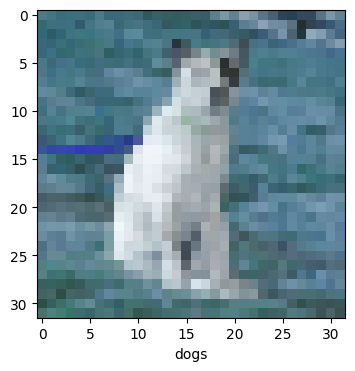

In [5]:
image = TRAIN_DATA[0][0]                                # Image
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.xlabel(CATEGORIES[TRAIN_DATA[0][1]])                # Label

Converting all 3000 images to grayscale (32 x 32) for reducing computaion time

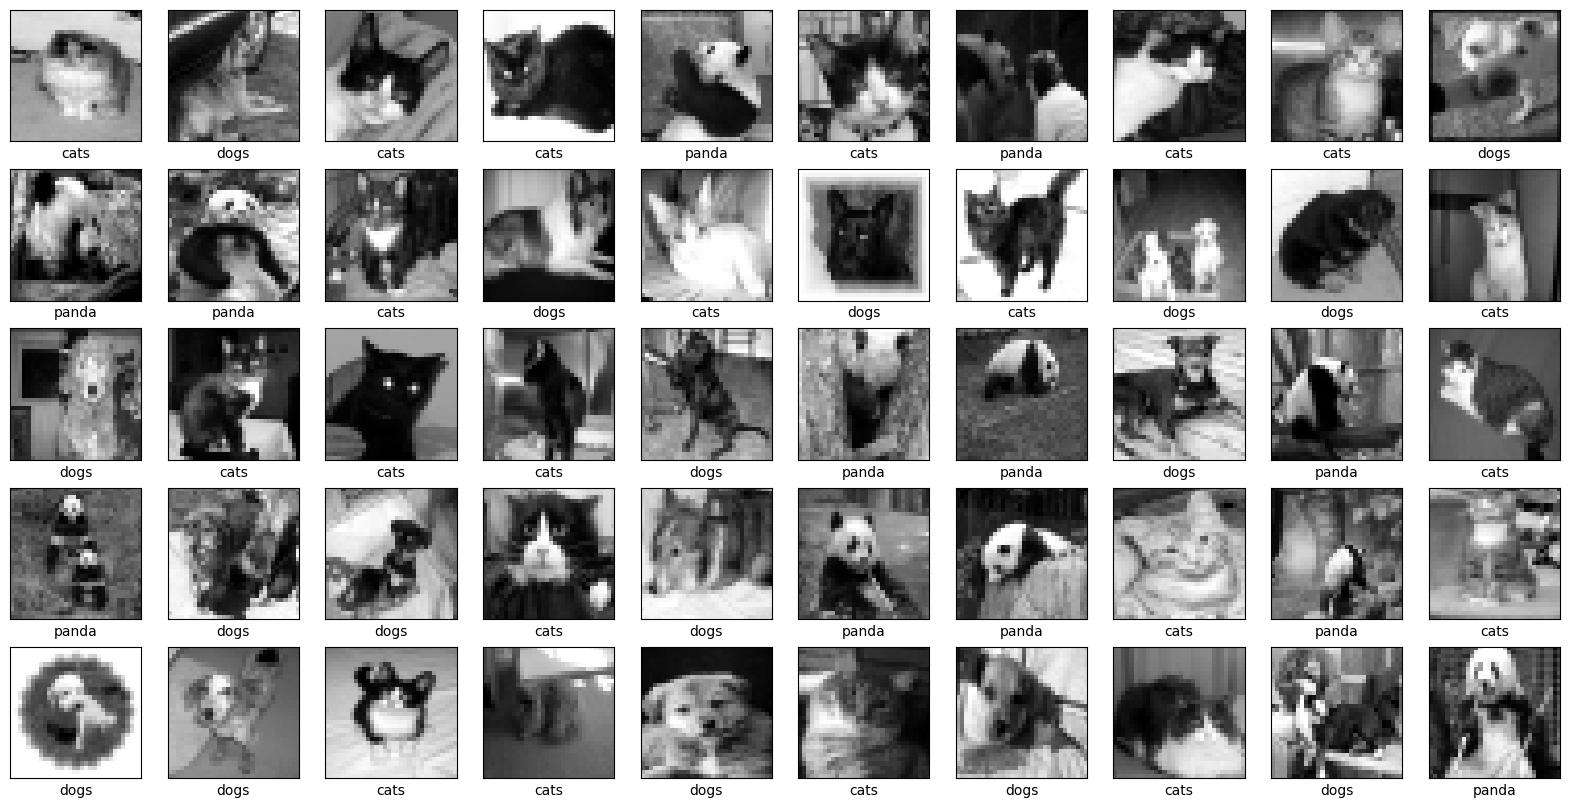

In [6]:
random.shuffle(TRAIN_DATA)                                          # Shuffling ensures that the displayed images are not biased towards the order they were loaded in.

plt.figure(figsize=(20,10))                                         # 20 width 10 height

for i in range(50):
    plt.subplot(5, 10, i+1)                                         # A grid layout with 5 rows and 10 columns. i+1 argument defines the position of the current subplot within the grid
    image = TRAIN_DATA[i][0]                                        # Each element in TRAIN_DATA is a list containing an image array and a class label. Here, [0] selects the image array.
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)              # Convert image to grayscale
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])                        # [1] selects the image array label.
    plt.xticks([])
    plt.yticks([])
    plt.axis()
    if i == 50:                                                     # Displaying the first 50 images
        break
plt.show()

### **Model Building and Evaluation:**

The dataset `TRAIN_DATA` gets divided into `5` separate `folds` for `cross validation`, each containing `600` elements.

In [7]:
f1 = TRAIN_DATA[0:600]
f2 = TRAIN_DATA[600:1200]
f3 = TRAIN_DATA[1200:1800]
f4 = TRAIN_DATA[1800:2400]
f5 = TRAIN_DATA[2400:3000]

Calculates the distances between images in the `training` and `validation` sets, sorting them based on these distances, and then evaluates the `accuracy` of the k-NN classifier for different values of `k`

`by_l1_dist(list)`: Returns the L1 distance from the third element of the input list. Used for sorting lists based on L1 distance.

`by_l2_dist(list)`: Returns the L2 distance from the third element of the input list. Used for sorting lists based on L2 distance.

`list[0]`: The label of the validation example. <br>
`list[1]`: The label of the training example. <br>
`list[2]`: A dictionary containing the distances calculated `({"l1": l1_dist, "l2": l2_dist})`.

In [8]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

`distance_calc(train_fold, valid_fold)`:
Calculates L1 and L2 distances between each image in the validation set and each image in the training set.
Stores the distances, along with image labels, in a list.
Sorts the list by L1 and L2 distances and selects the top `top_filter` nearest neighbors for each validation image.
Returns a list containing L1 and L2 distance results.

`top_filter`: The number of nearest neighbors to consider for each validation image.

`k_range`: The maximum value of K to test for accuracy.


In [9]:
top_filter = 20                                                                             # Number of nearest neighbors to consider for each validation image.
def distance_calc(train_fold, valid_fold):                                                  # Calculates L1 and L2 distances between each image in the validation set
    l1_result = []                                                                          # Manhattan (L1) distance.
    l2_result = []                                                                          # Euclidean (L2) distance
    for valid in tqdm(valid_fold):
        temp_dist_list = []                                                                 # Store the distance between the validation example and every training example
        for train in train_fold:
            l1_dist = np.sum(np.abs(valid[0]-train[0]))                                     # Manhattan
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))                                 # Euclidean
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)                                                 # Sort
        l1_result.append(temp_dist_list[:top_filter])                                       # by the L1 distance, and the top top_filter nearest neighbors are added to l1_result.
        temp_dist_list.sort(key=by_l2_dist)                                                 # Sort
        l2_result.append(temp_dist_list[:top_filter])                                       # by the L2 distance, and the top top_filter nearest neighbors are added to l2_result.
    return [l1_result, l2_result]

`cal_accuracy(dist_result, dist_term)`:
Calculates accuracy for different values of K in the KNN algorithm.
For each value of K, it counts the number of correct predictions for each validation image.
If there's a tie in the number of nearest neighbors from each class, the distance is used to break the tie. Returns a list of accuracies for different values of K.

`dist_result`: A list of sorted nearest neighbors (either l1_result or l2_result). <br>
`dist_term`: A string that indicates whether to use 'l1' or 'l2' for tie-breaking when calculating accuracy.

The function calculates the accuracy by considering the top k nearest neighbors for each validation example. It checks how many of the k nearest neighbors belong to the same class as the validation example (same_class). If k is odd, the validation example is classified correctly if the majority of the k neighbors belong to the same class. if k is even and there is a tie, it breaks the tie by comparing the sum of the distances for the same class neighbors and different class neighbors.

In [10]:
k_range = 20
def cal_accuracy(dist_result, dist_term):                                                   # Calculates accuracy for different values of K in the KNN algorithm
    k_accuracies = []                                                                       # A list of accuracies for different values of k
    for k in range(1, k_range+1):
        img_accuracy = 0                                                                    # Keep track of how many validation images are correctly classified for the current value of k
        for valid_img in dist_result:
            nn = valid_img[:k]                                                              # Extracts the top k nearest neighbors for the current validation image from valid_img.
            same_class = [n for n in nn if n[0] == n[1]]                                    # A list of neighbors that belong to the same class as the validation image.
            same_class_len = len(same_class)                                                # [n[0] -> class label -> validation image] [n[1] -> class label -> training image (neighbor)]
            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:                                            # Checks if the number of neighbors from the same class is more than half of k. If it is, the image is considered correctly classified.
                    img_accuracy += 1                                                       # Increments the accuracy counter by 1 if the image is correctly classified
            else:
                diff_class = [n for n in nn if n[0] != n[1]]                                # Creates a list of neighbors that do not belong to the same class as the validation image.
                if same_class_len > len(diff_class):                                        # Checks if there are more neighbors from the same class than from different classes. If so, the image is considered correctly classified.
                    img_accuracy += 1
                elif same_class_len == len(diff_class):                                     # Tie (equal neighbour)
                    same_class_dist = sum([n[2][dist_term] for n in same_class])            # Sums the distances for neighbors
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])            # Sums the distances for neighbors
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))                                  # Accuracy for the current k by dividing the number of correctly classified images by the total number of validation images
    return k_accuracies

For cross-validation, specifically 5-fold cross-validation. Here, the dataset is split into five subsets (or folds), and the model is trained and validated five times, each time using a different subset as the validation set and the remaining four as the training set. After each fold, it calculates a distance metric using the `distance_calc` function and stores these results in `dist_by_fold`. Finally, the length of one of the elements of the first fold's result is printed.

In [11]:
dist_by_fold = []

for i in range(5):
    if i == 0:
        train = f2 + f3 + f4 + f5
        validation = f1
    elif i == 1:
        train = f1 + f3 + f4 + f5
        validation = f2
    elif i == 2:
        train = f1 + f2 + f4 + f5
        validation = f3
    elif i == 3:
        train = f1 + f2 + f3 + f5
        validation = f4
    elif i == 4:
        train = f1 + f2 + f3 + f4
        validation = f5

    dist_by_fold.append(distance_calc(train, validation))

print()
len(dist_by_fold[0][0])

100%|██████████| 600/600 [00:46<00:00, 12.96it/s]

600

In [12]:
# Testing
# for i in dist_by_fold[0][0]:
#     print(i)

### **Results and Analysis:**

Plotting accuracy for L1 and L2 `distances` for different values of `k`. accuracies is an empty list is created to store the accuracy values for different K values for both L1 and L2 distances. A loop iterates over each result in `dist_by_fold`. This variable holds the distances calculated for each fold in a cross-validation process.

In [13]:
accuracies = []                                                         # Each element in the accuracies list will be a list of two lists: one for L1 accuracy and one for L2 accuracy across all values of k.

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")                         # Calculate the accuracy using the L1
    l2_accuracy = cal_accuracy(result[1], "l2")                         # Calculate the accuracy using the L2
    accuracies.append([l1_accuracy, l2_accuracy])                       # Appends a list containing the l1_accuracy and l2_accuracy results for the current fold to the accuracies list.

print(accuracies)

[[[0.47333333333333333, 0.4033333333333333, 0.415, 0.38, 0.36, 0.3466666666666667, 0.33166666666666667, 0.32, 0.3233333333333333, 0.32, 0.31666666666666665, 0.32166666666666666, 0.31, 0.31, 0.3, 0.29833333333333334, 0.3, 0.28833333333333333, 0.2733333333333333, 0.2733333333333333], [0.2833333333333333, 0.2866666666666667, 0.235, 0.23833333333333334, 0.20666666666666667, 0.22666666666666666, 0.17833333333333334, 0.19833333333333333, 0.16666666666666666, 0.18, 0.17, 0.18, 0.17166666666666666, 0.18, 0.18, 0.18333333333333332, 0.17166666666666666, 0.17, 0.16166666666666665, 0.16]], [[0.43666666666666665, 0.41833333333333333, 0.38333333333333336, 0.36, 0.365, 0.335, 0.33, 0.325, 0.32166666666666666, 0.31, 0.3, 0.30333333333333334, 0.30833333333333335, 0.29333333333333333, 0.28833333333333333, 0.2783333333333333, 0.2833333333333333, 0.26166666666666666, 0.2633333333333333, 0.25166666666666665], [0.32666666666666666, 0.3016666666666667, 0.3, 0.2633333333333333, 0.25333333333333335, 0.22, 0.20

For L1 Distance:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.4733, 0.4033, 0.415, 0.38, 0.36, 0.3467, 0.3317, 0.32, 0.3233, 0.32, 0.3167, 0.3217, 0.31, 0.31, 0.3, 0.2983, 0.3, 0.2883, 0.2733, 0.2733]
Max accuracy:  0.4733
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.4367, 0.4183, 0.3833, 0.36, 0.365, 0.335, 0.33, 0.325, 0.3217, 0.31, 0.3, 0.3033, 0.3083, 0.2933, 0.2883, 0.2783, 0.2833, 0.2617, 0.2633, 0.2517]
Max accuracy:  0.4367
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.4283, 0.38, 0.345, 0.3483, 0.3467, 0.3383, 0.335, 0.3317, 0.3233, 0.3183, 0.3, 0.295, 0.2967, 0.2583, 0.2717, 0.2683, 0.265, 0.2617, 0.26, 0.2533]
Max accuracy:  0.4283
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.435, 0.4517, 0.38, 0.3933, 0.375, 0.3483, 0.3417, 0.3333, 0.3317, 0.32, 0.32, 0.3267, 0.3217, 0.3133, 0.3117, 0.3133, 0.3033, 0.2867, 0.285, 0.285]
Max accuracy:  0.4517
[1, 2, 3, 4, 5,

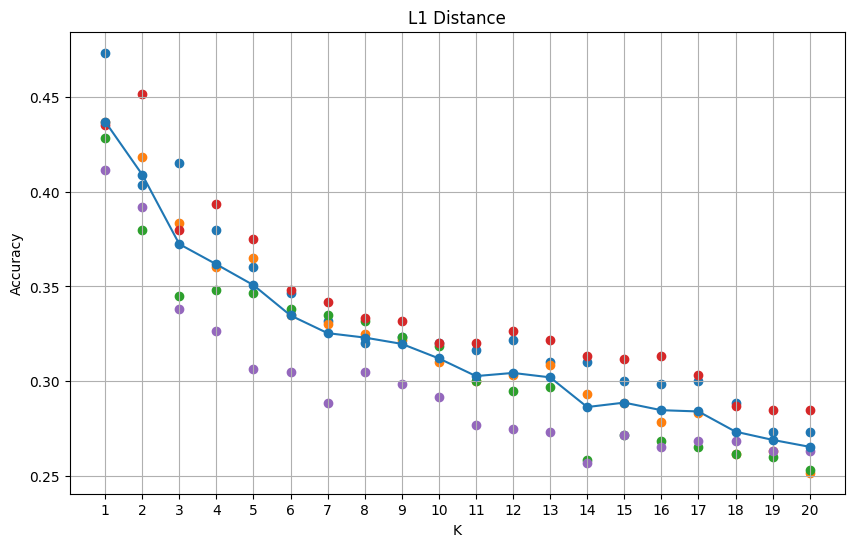

For L2 Distance:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.2833, 0.2867, 0.235, 0.2383, 0.2067, 0.2267, 0.1783, 0.1983, 0.1667, 0.18, 0.17, 0.18, 0.1717, 0.18, 0.18, 0.1833, 0.1717, 0.17, 0.1617, 0.16]
Max accuracy:  0.2867
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3267, 0.3017, 0.3, 0.2633, 0.2533, 0.22, 0.2033, 0.195, 0.1633, 0.1333, 0.1217, 0.1317, 0.115, 0.1033, 0.0967, 0.09, 0.0833, 0.0917, 0.0817, 0.08]
Max accuracy:  0.3267
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3017, 0.3067, 0.2583, 0.2533, 0.2367, 0.2133, 0.1983, 0.195, 0.1833, 0.1567, 0.1517, 0.14, 0.1333, 0.14, 0.1367, 0.15, 0.1367, 0.1483, 0.13, 0.155]
Max accuracy:  0.3067
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3283, 0.3017, 0.2733, 0.2883, 0.26, 0.2517, 0.2267, 0.2217, 0.2033, 0.1983, 0.1817, 0.1617, 0.1583, 0.1517, 0.1367, 0.1267, 0.1217, 0.1333, 0.12, 0.1067]
Max accuracy:  0.3283
[1,

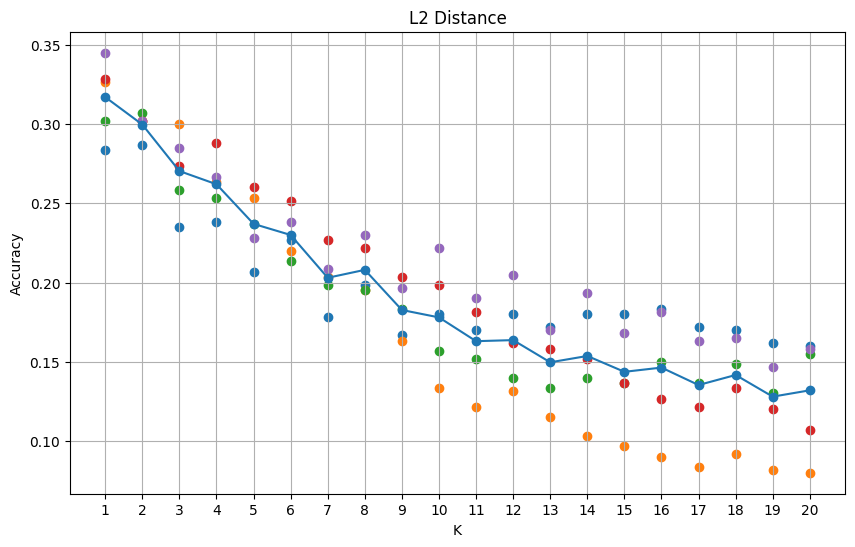

In [14]:
print("For L1 Distance:")
x_list = list(range(1, k_range+1))                                          # k values ranging from 1 to 20, a list x_list that contains integers from 1 to 20
plt.figure(figsize=(10, 6))

for fold in accuracies:                                                     # Each fold contains a pair of accuracy lists (L1 and L2 accuracies).
    y_list = fold[0]                                                        # Extracts the L1 accuracy list (fold[0]) for the current fold and stores it in y_list. This list contains accuracy values for different values of k.
    print(x_list)
    numbers = y_list
    rounded_numbers = [round(num, 4) for num in numbers]                    # Rounds each accuracy value in numbers to 4 decimal places
    print(rounded_numbers)
    print("Max accuracy: ", max(rounded_numbers))
    plt.scatter(x_list, y_list)                                             # Plots the accuracy values (y_list) against the k values (x_list) as a scatter plot for the current fold.

arr = []                                                                    # Used to collect accuracy values for all folds at each k.
for i in range(k_range):
    arr.append([fold[0][i] for fold in accuracies])                         # Creates a list of accuracies across all folds for that specific k value and appends it to arr. fold[0][i] accesses the ith accuracy value from the L1 accuracy list of each fold.
trend = [np.mean(a) for a in arr]                                           # Calculates the mean accuracy across all folds for each k

plt.errorbar(x_list, trend, fmt='-o')                                       # Plots the trend line (average accuracy across all folds)
plt.title('L1 Distance')
plt.xticks(x_list)                                                          # Sets the X-axis ticks to the values in x_list (K values).
plt.grid(True)                                                              # Enables a grid on the plot for better readability.
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()


print("For L2 Distance:")
x_list = list(range(1, k_range+1))
plt.figure(figsize=(10, 6))

for fold in accuracies:
    y_list = fold[1]                                                        # Loops through each fold in accuracies and extracts the L2 accuracy list
    print(x_list)
    numbers = y_list
    rounded_numbers = [round(num, 4) for num in numbers]                    # Rounds each accuracy value in numbers to 4 decimal places
    print(rounded_numbers)
    print("Max accuracy: ", max(rounded_numbers))
    plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
    arr.append([fold[1][i] for fold in accuracies])                         # Creates a list of accuracies across all folds for that specific k value and appends it to arr. fold[0][i] accesses the ith accuracy value from the L1 accuracy list of each fold.
trend = [np.mean(a) for a in arr]                                           # Calculates the mean accuracy across all folds for each k

plt.errorbar(x_list, trend, fmt='-o')                                       # Plots the trend line (average accuracy across all folds)
plt.title('L2 Distance')
plt.xticks(x_list)                                                          # Sets the X-axis ticks to the values in x_list (K values).
plt.grid(True)                                                              # Enables a grid on the plot for better readability.
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

### **Discussion:**

**Manhattan Distance L1**

The Manhattan distance between two images is calculated by treating the images as vectors of pixel intensity values and then computing the Manhattan distance between these vectors. For each corresponding pair of pixel values in the two vectors, the absolute difference is calculated.

**Euclidian Distance L2**

The Euclidean distance between two image is calculated by treating the images as vectors of pixel intensity values and then computing the Euclidean distance between these vectors. For each corresponding pair of pixel values in the two vectors, the squared difference is calculated.

**Accuracy**

The accuracy depends on the characteristics of the images and in this case for 3 classes `3000 total images` the` Manhattan Distance (L1)` metric gave better performance in accuracy compare to `Euclidian Distance metric (L2)`. The accuracy in L1 distance was `42%` when `k = 1`. However the accuracy in L2 distance was `32.3%` when `k = 1`. The increasing number of nearest neigbours has negative impact on the accuracy for chances of getting tied in terms of prediction.

Manhattan distance can produce better results than Euclidian distance, especially when dealing with sparse high-dimensional data or when outliers are present. It can be used to compare pixel values or feature vectors.



**Limitations**

The KNN algorithm has limitations in terms of scalability and the training process. For our dataset there was 3000 total images and the computational time increases for the increase in dataset. For loading each images into the dataset total time was 19 seconds and for 5 fold validation total time was `7.74 min`.

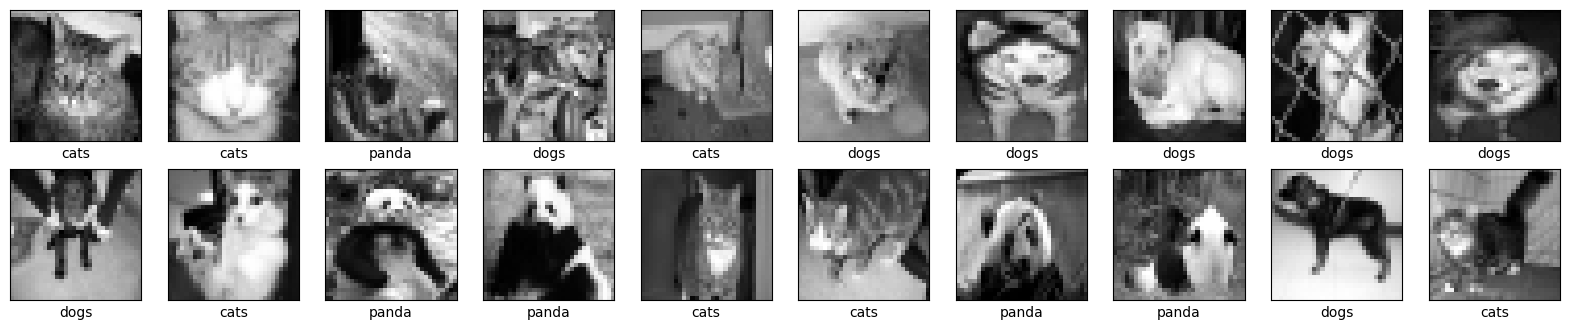

In [15]:
def l1_dist(image1, image2):                                                                        # Manhattan (L1)
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):                                                                        # Euclidian (L2)
    return np.sqrt(np.sum((image1 - image2) ** 2))

random.shuffle(TRAIN_DATA)                                                                          # Shuffles the train data
test_images = []

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    test_images.append([image_gray, CATEGORIES[TRAIN_DATA[i][1]]])
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 19:
        break

### **Top 5 prediction:**

Comparing a set of test images against a training dataset using two different distance metrics L1 (Manhattan distance) and L2 (Euclidean distance). Calculates the distances between each test image and all training images, then displays the top 5 closest matches for both distance metrics, along with their respective distances and predicted classes.

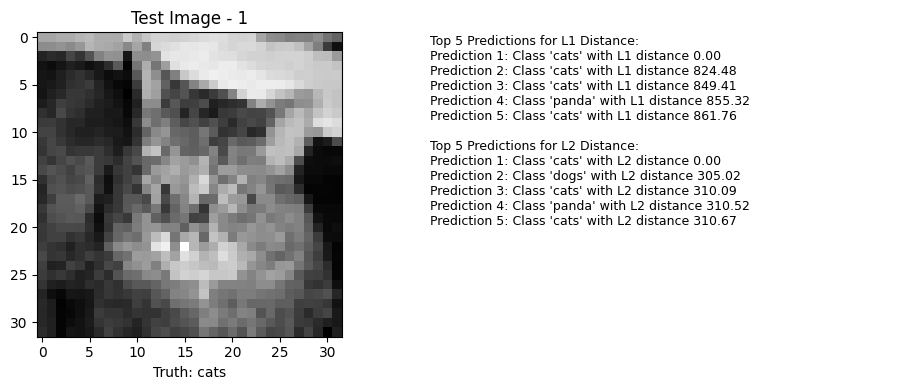

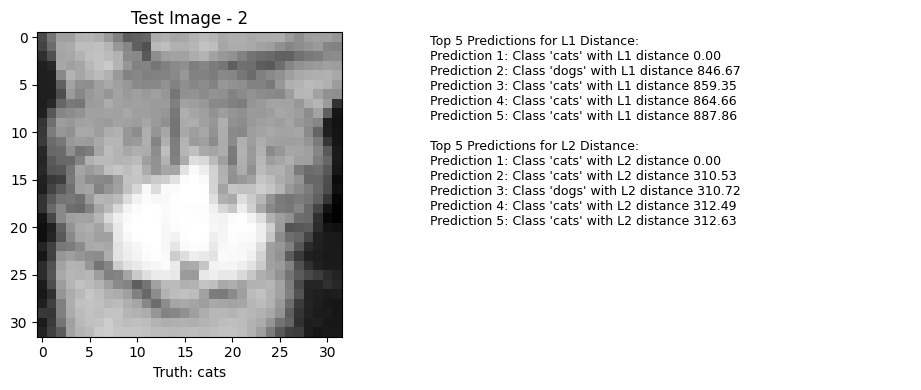

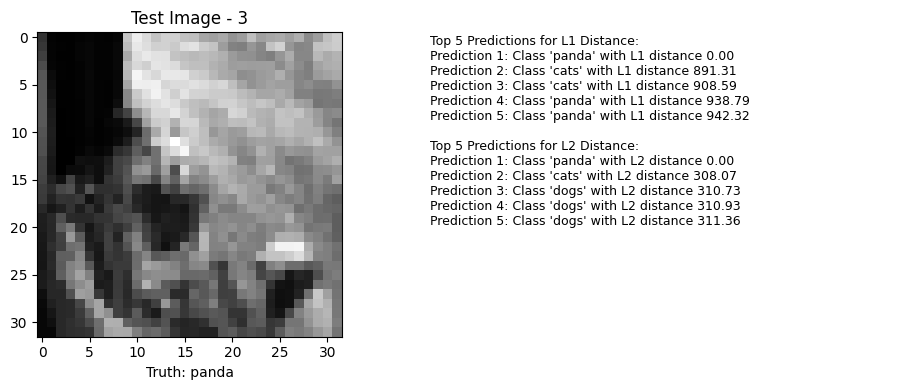

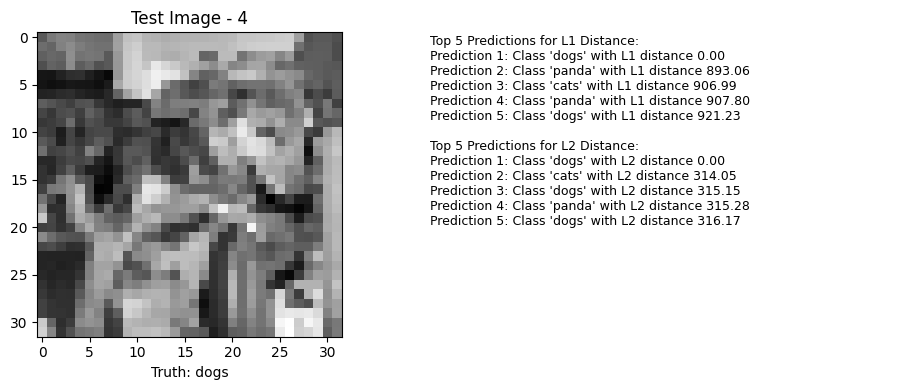

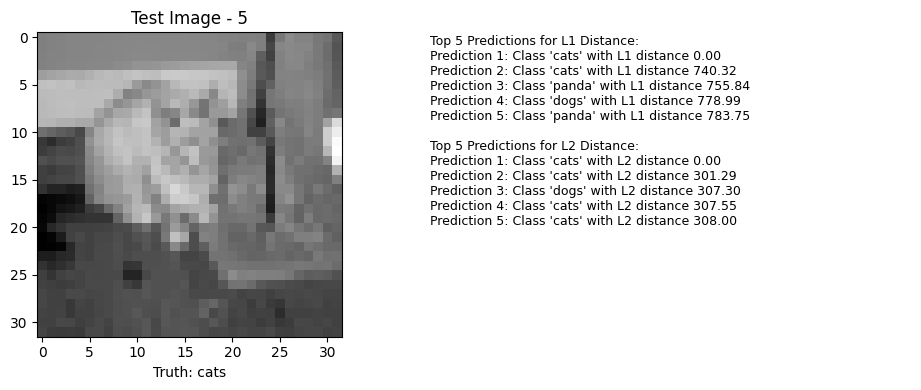

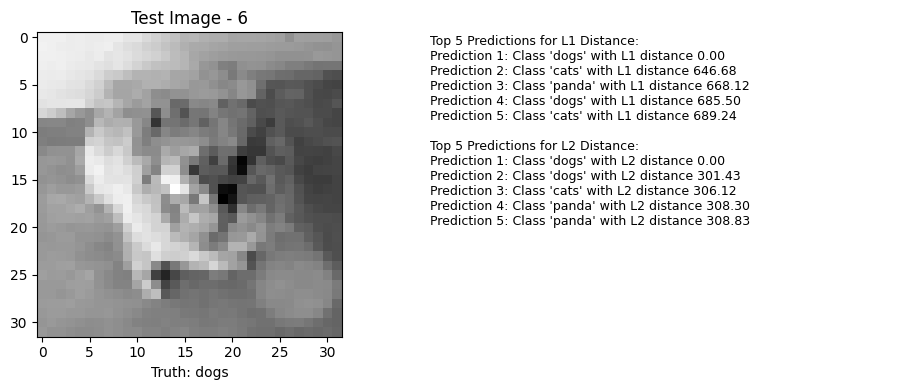

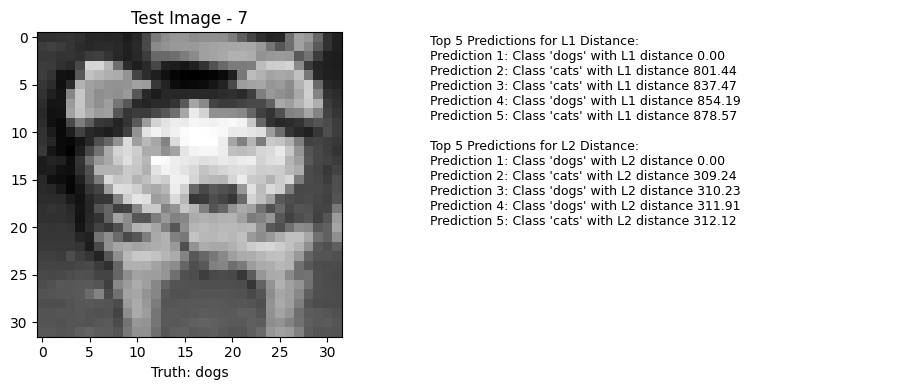

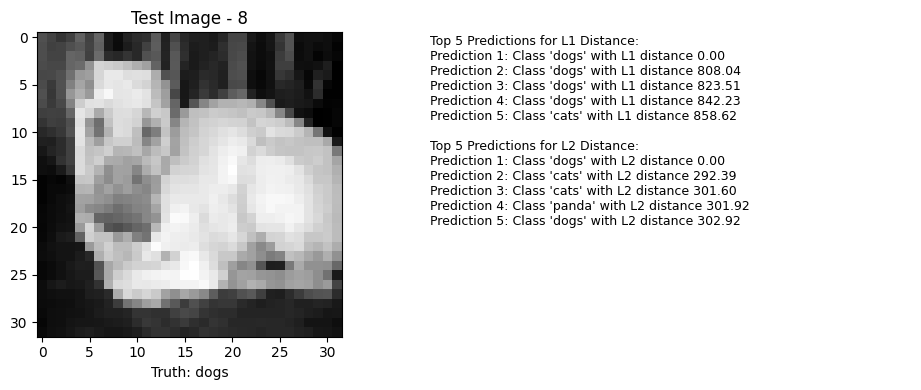

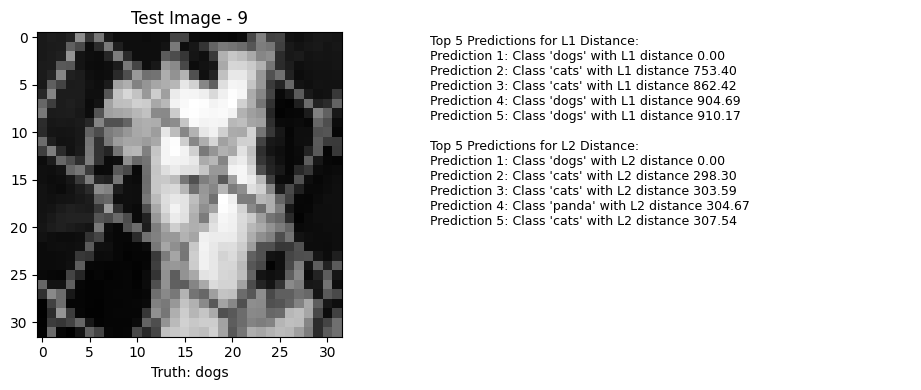

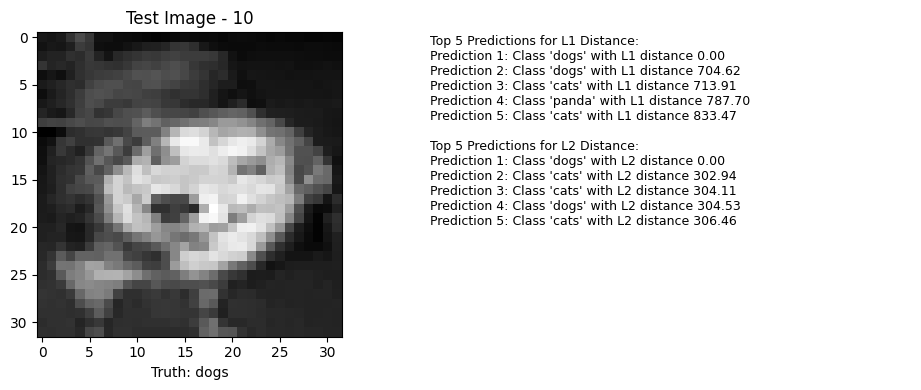

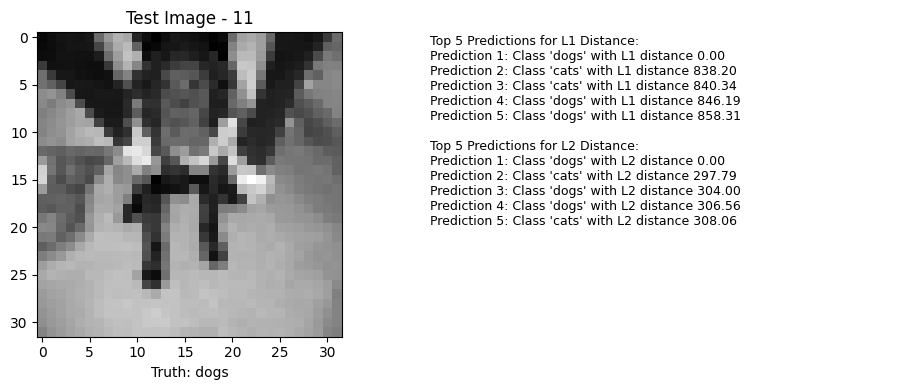

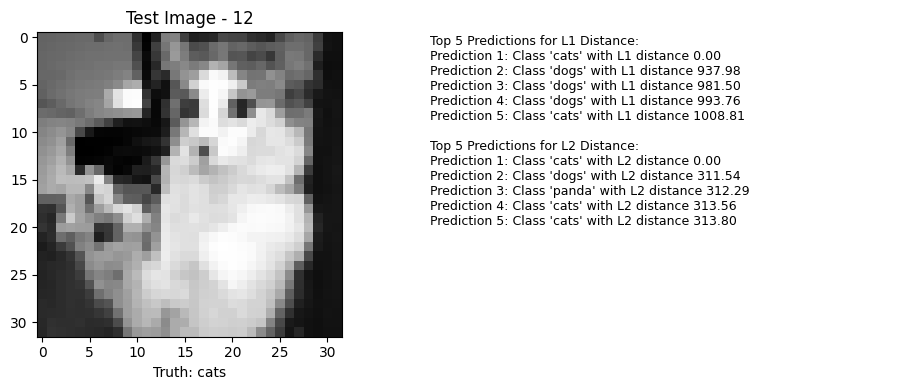

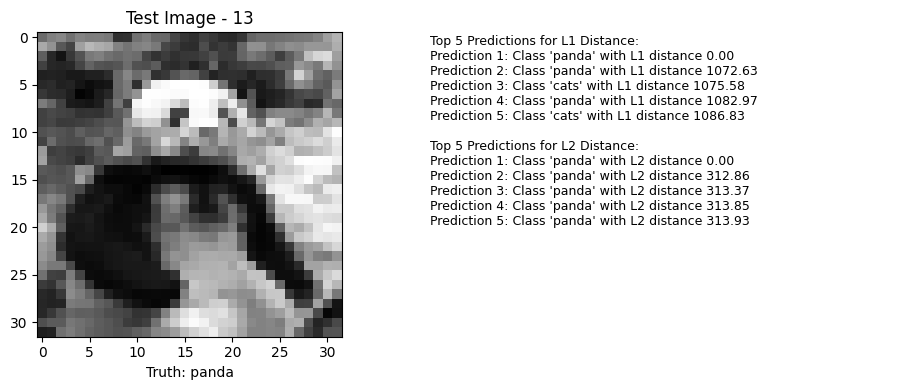

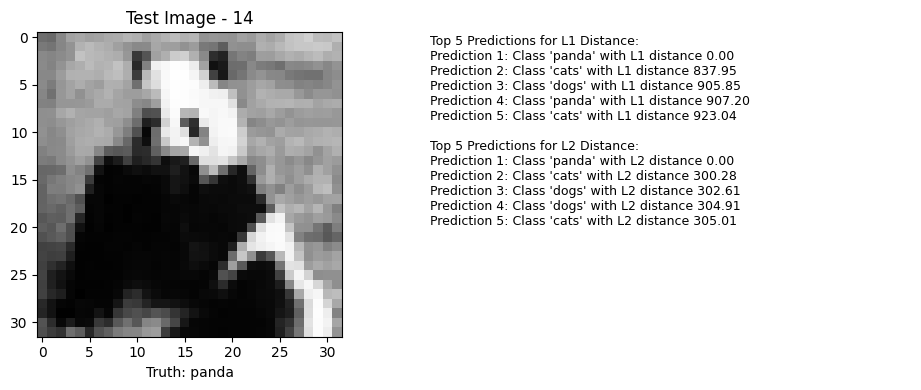

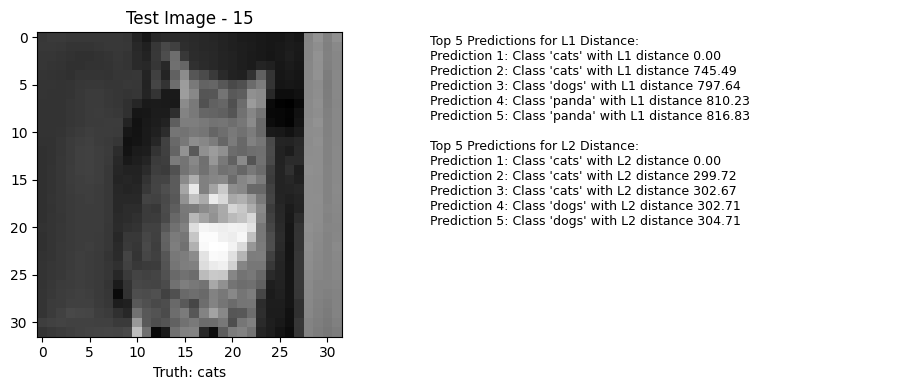

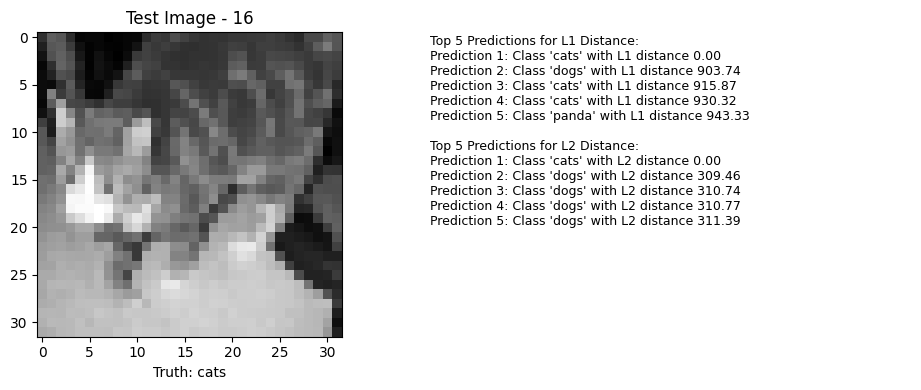

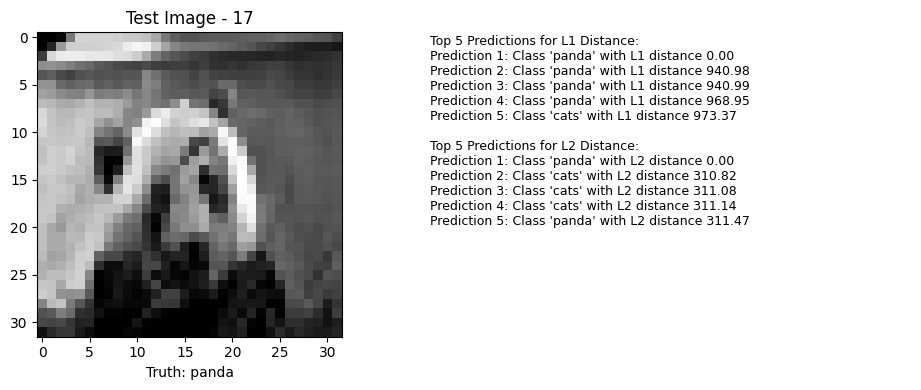

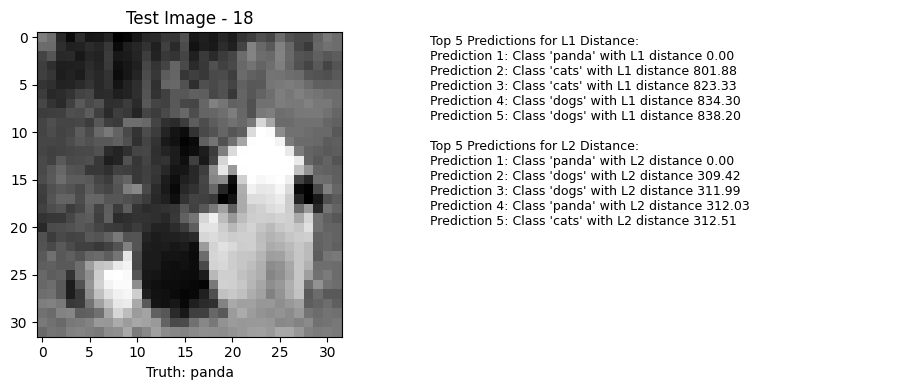

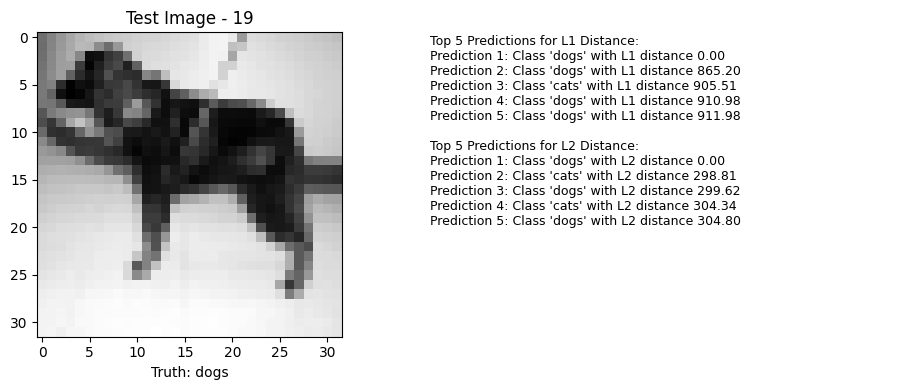

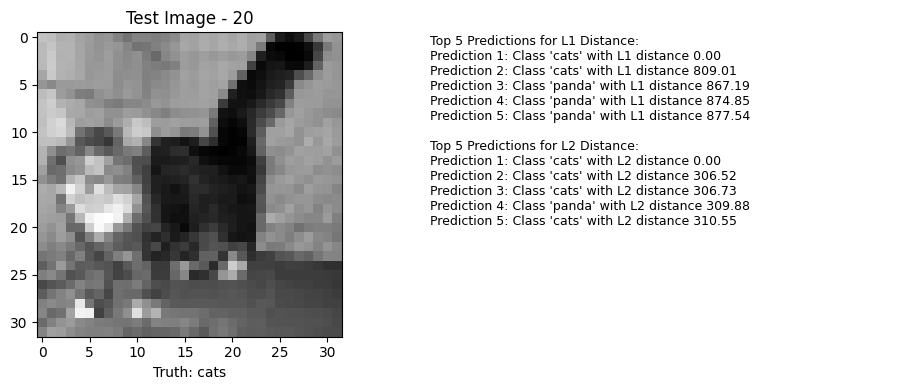

In [16]:
for i, test_image_gray in enumerate(test_images):                                                               # Each test image in the list, processing one image per iteration.
    fig, text = plt.subplots(1, 2, figsize=(10, 4))                                                             # Creates a figure (fig) with two subplots (text[0] and text[1]) arranged side by side (1 row, 2 columns).


    text[0].imshow(test_image_gray[0], cmap="gray")                                                             # Display the test image on the left subplot
    text[0].set_title(f"Test Image - {i+1}")
    text[0].set_xlabel(f'Truth: {CATEGORIES[TRAIN_DATA[i][1]]}')

    distances1 = []                                                                                             # Calculate L1 distances and predictions

    for train_image, class_num in TRAIN_DATA:                                                                   # Iterates over all images in the training dataset
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray[0], train_image_gray)                                                   # Computes the L1 (Manhattan) distance between the grayscale test image and the grayscale training image
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])


    distances2 = []                                                                                             # Calculate L2 distances and predictions

    for train_image, class_num in TRAIN_DATA:                                                                   # Iterates over all images in the training dataset
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)                                                   # Computes the L2 (Euclidean) distance between the grayscale test image and each grayscale training image
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    # Display predictions on the right subplot
    predictions_text = "Top 5 Predictions for L1 Distance:\n"
    for j, (dist1, class_num) in enumerate(distances1[:5]):                                                     # Iterates over the top 5 closest training images based on L1 distance
        predicted_class = CATEGORIES[class_num]
        predictions_text += f"Prediction {j+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}\n"

    predictions_text += "\nTop 5 Predictions for L2 Distance:\n"
    for j, (dist2, class_num) in enumerate(distances2[:5]):                                                     # Iterates over the top 5 closest training images based on L2 distance
        predicted_class = CATEGORIES[class_num]
        predictions_text += f"Prediction {j+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}\n"

    text[1].text(0.01,
                 0.99,
                 predictions_text,
                 fontsize=9,
                 verticalalignment='top')

    text[1].axis('off')                                                                                         # Hide axis

    plt.tight_layout()
    plt.show()

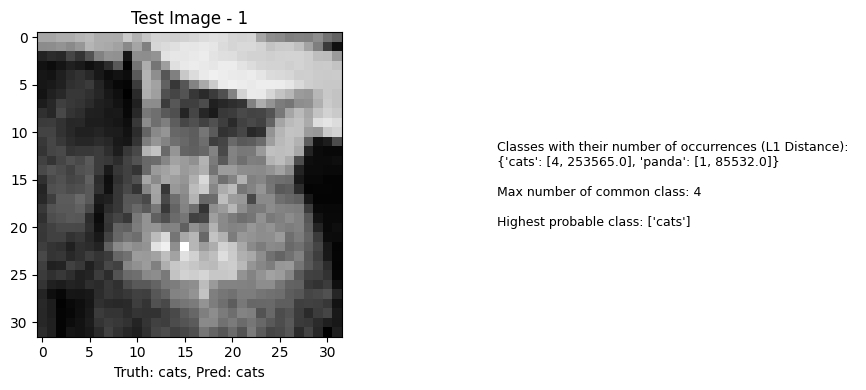

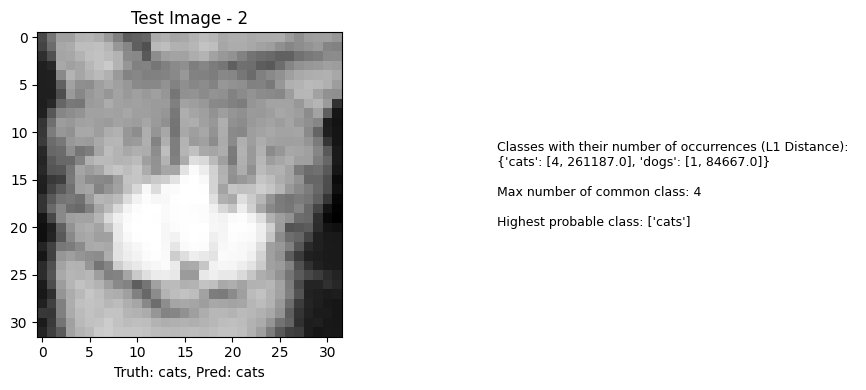

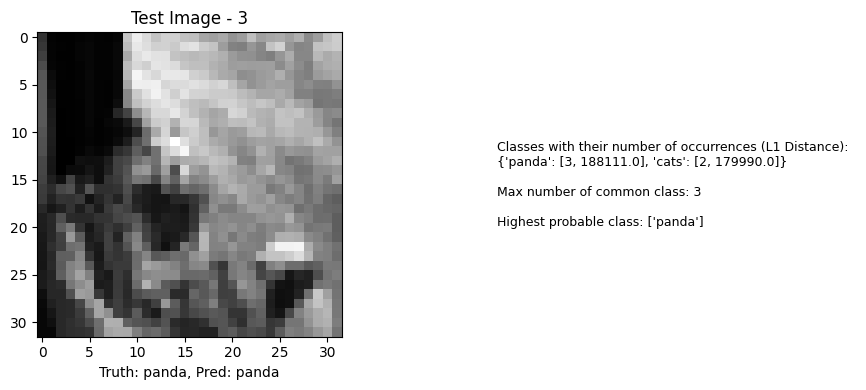

Class with the least error: ['cats'], Error: 90699.0


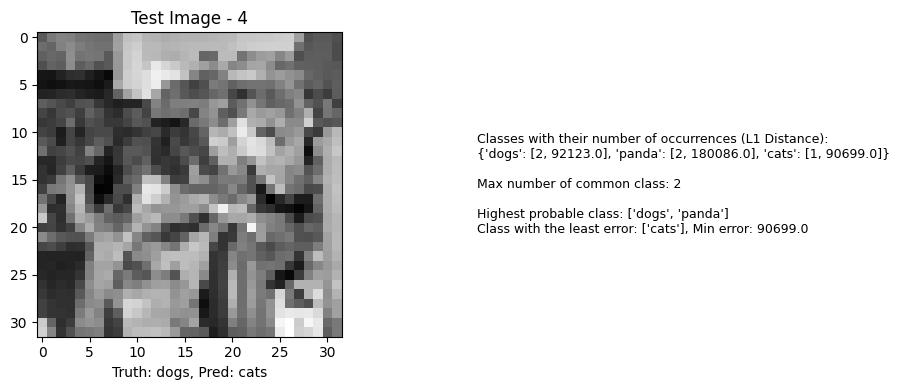

Class with the least error: ['cats'], Error: 74032.0


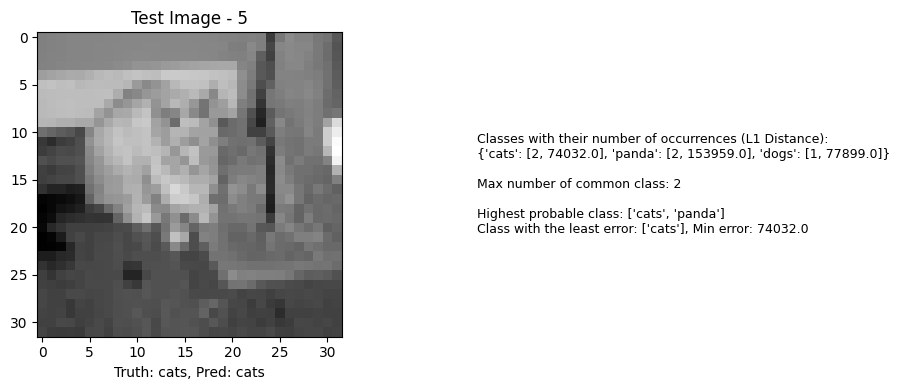

Class with the least error: ['panda'], Error: 66812.0


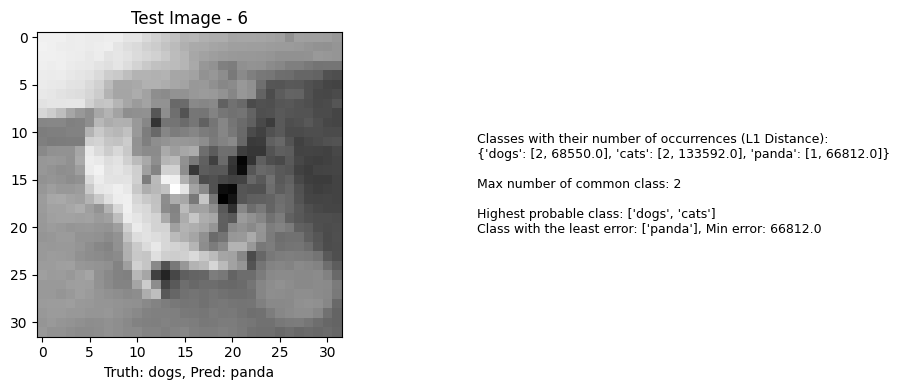

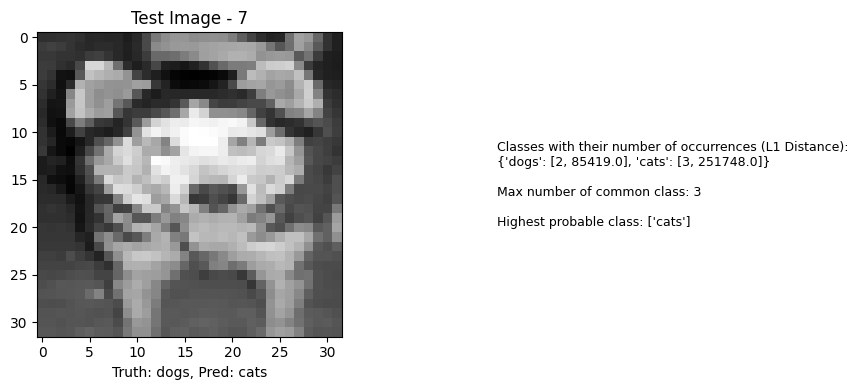

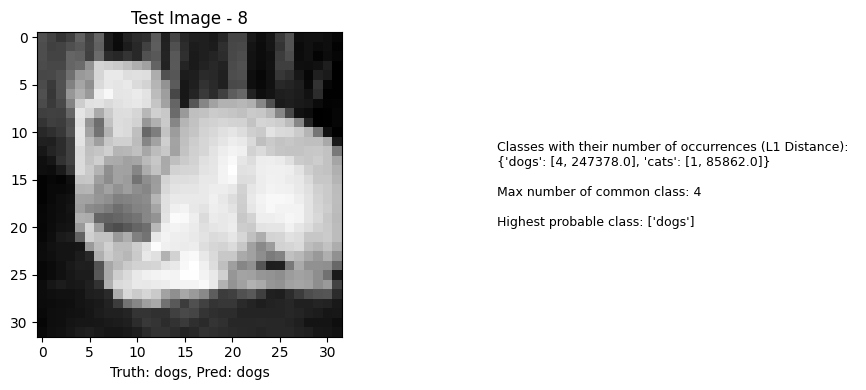

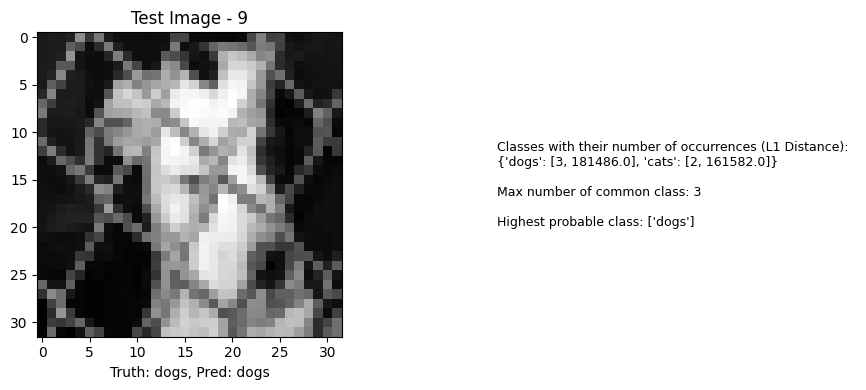

Class with the least error: ['dogs'], Error: 70462.0


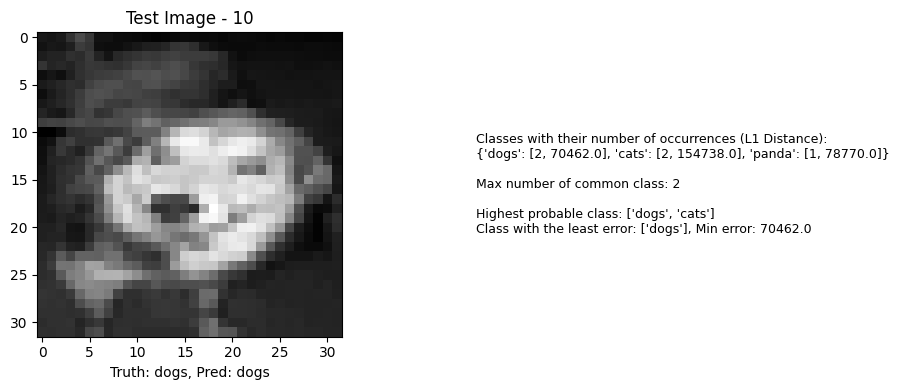

Correctly predicted 7 images out of 10, overall accuracy: 70.00%


In [17]:
# random.shuffle(TRAIN_DATA)

test_images = []
neighbours = 5                                                                                                              # Number of neighbors to consider for k-NN
test_count = 10                                                                                                             # Number of test images to evaluate

for i in range(test_count):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, TRAIN_DATA[i][1]])

accurate = 0                                                                                                                # Counter for accurate predictions

for i, test_image_gray in enumerate(test_images):
    distances1 = []                                                                                                         # List to store L1 distances and corresponding class labels
    pred = None

    for train_image, class_num in TRAIN_DATA:                                                                               # Calculate L1 distances between the test image and all training images
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray[0], train_image_gray)
        distances1.append((dist1, class_num))

    distances1.sort(key=lambda x: x[0])                                                                                     # Sort distances in ascending order

    prediction_classes = [[cl[0], CATEGORIES[cl[1]]] for cl in distances1[:neighbours]]                                     # Get the top 'neighbours' closest images (smallest L1 distances)

    occurrences_dict = {pc[1]: [0, 0] for pc in prediction_classes}                                                         # Count occurrences and sum distances for each predicted class

    for pc in prediction_classes:
        occurrences_dict[pc[1]][0] += 1                                                                                     # Increasing the count for each predicted class.
        occurrences_dict[pc[1]][1] += pc[0]                                                                                 # Summing the distances for each predicted class.


    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)                                                                                  # Find the class with the maximum occurrence (k-NN majority vote)
    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]                       # Identify the class(es) with the maximum occurrence



    if len(keys_with_max_value) == 1:                                                                                       # If there's a single class with the max count, choose it as the prediction
        pred = keys_with_max_value[0]
    else:
        elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
        min_count_1 = min(elements_at_index_1)                                                                              # If there are multiple classes with the max count, choose the one with the smallest sum of distances (least error)

        keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
        pred = keys_with_min_value[0]
        print(f'Class with the least error: {keys_with_min_value}, Error: {min_count_1}')

    truth = CATEGORIES[test_image_gray[1]]                                                                                  # Ground truth class label

    fig, text = plt.subplots(1, 2, figsize=(10, 4))                                                                         # Create a side-by-side display for image and text
    text[0].imshow(test_image_gray[0], cmap="gray")
    text[0].set_title(f"Test Image - {i+1}")
    text[0].set_xlabel(f"Truth: {truth}, Pred: {pred}")

    # Text output for the right subplot
    text_output = (f"Classes with their number of occurrences (L1 Distance): \n{occurrences_dict}\n\n"
                   f"Max number of common class: {max_count_0}\n\n"
                   f"Highest probable class: {keys_with_max_value}")

    if len(keys_with_max_value) > 1:
        text_output += (f"\nClass with the least error: {keys_with_min_value}, "
                        f"Min error: {min_count_1}")

    # Text on the right subplot
    text[1].text(0.2,
                 0.5,
                 text_output,
                 fontsize=9,
                 verticalalignment='center',
                 horizontalalignment='left')

    text[1].axis('off')                                                                                                     # Hide axis for the text display

    plt.tight_layout()
    plt.show()

    if truth == pred:
        accurate += 1                                                                                                       # Update accuracy count if prediction is correct

print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100:.2f}%')     # Display the overall accuracy


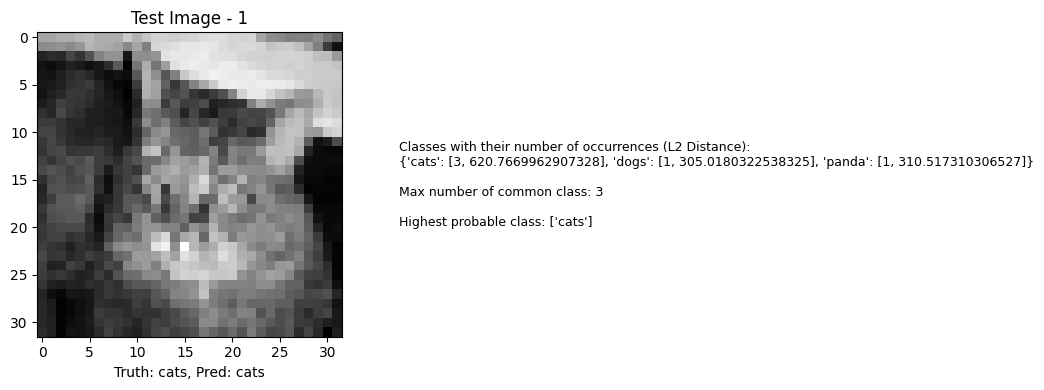

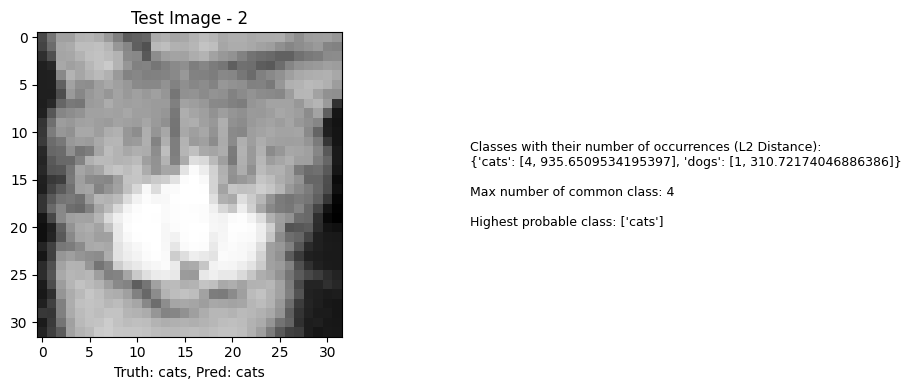

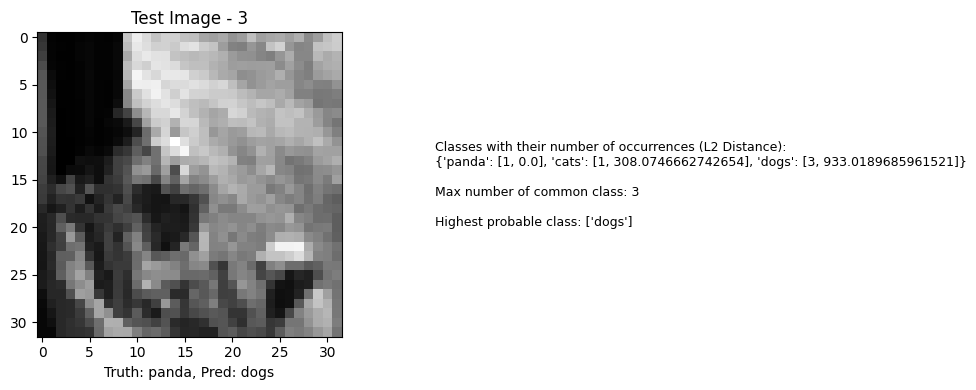

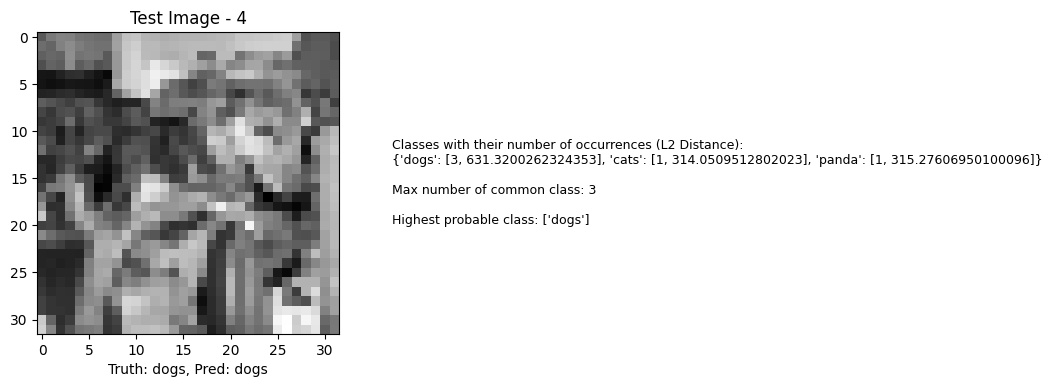

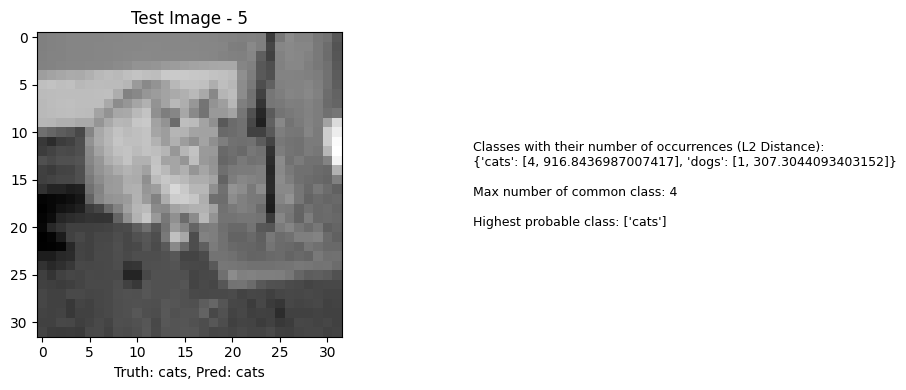

Class with the least error: (['dogs'], 301.4282667567858)


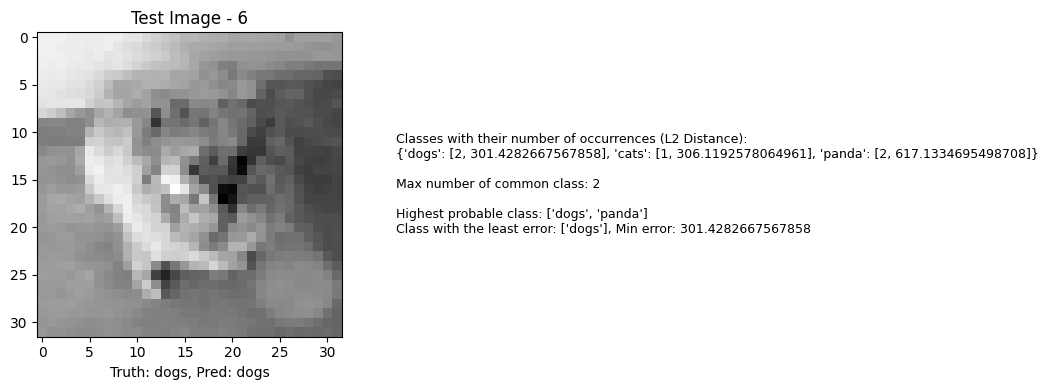

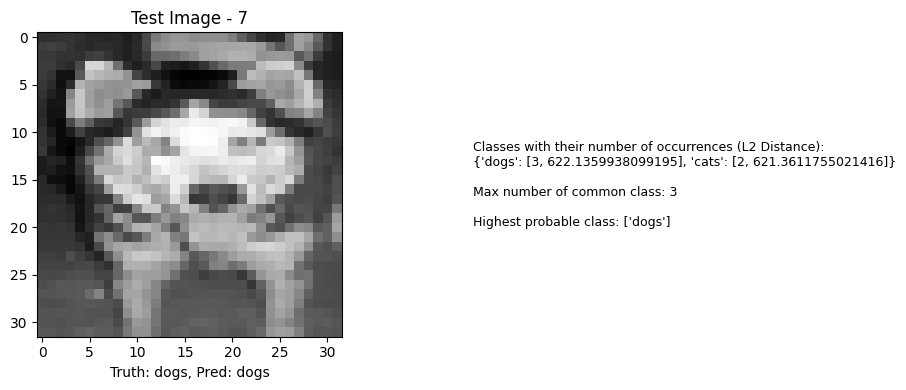

Class with the least error: (['panda'], 301.91886327289984)


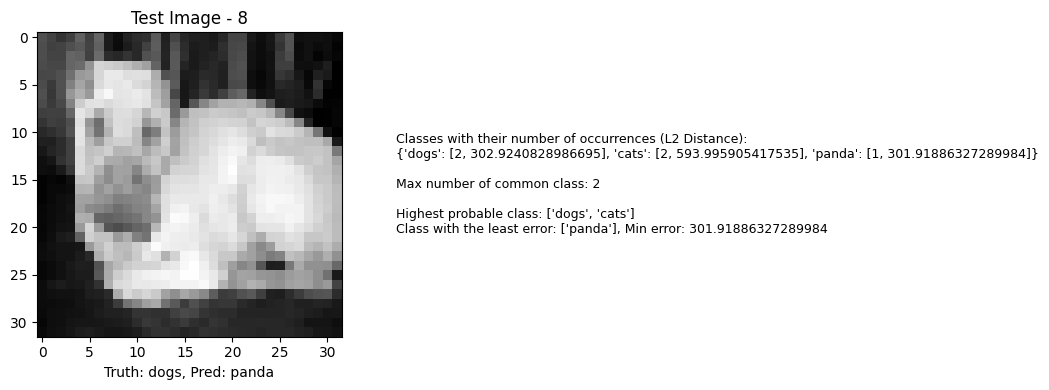

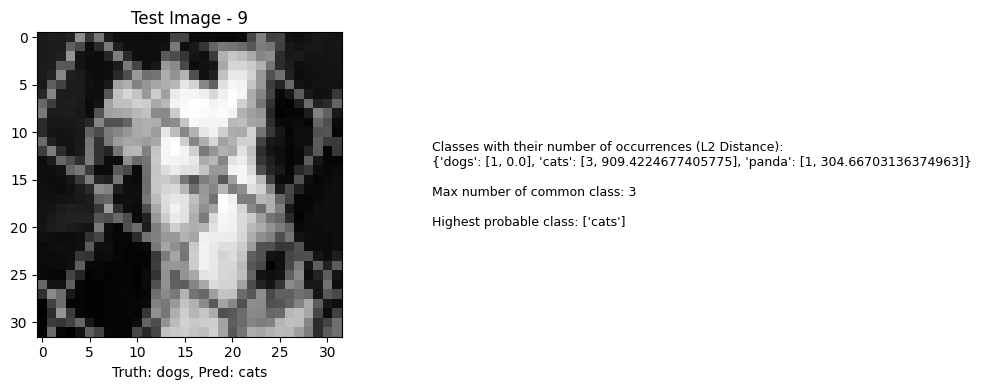

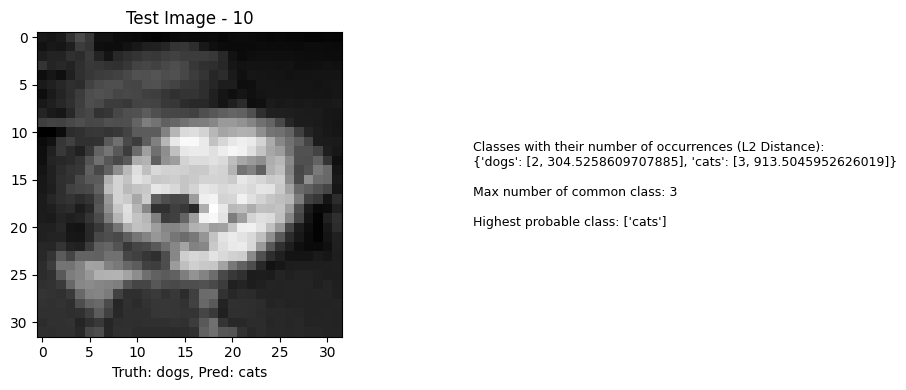

Correctly predicted 6 images out of 10, overall accuracy: 60.0 %


In [18]:
# random.shuffle(TRAIN_DATA)

test_images = []
neighbours = 5                                                                                                      # Number of neighbors to consider for k-NN
test_count = 10                                                                                                     # Number of test images to evaluate

for i in range(test_count):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, TRAIN_DATA[i][1]])

accurate = 0                                                                                                        # Counter for accurate predictions

for i, test_image_gray in enumerate(test_images):
    distances2 = []                                                                                                 # List to store L2 distances and corresponding class labels
    pred = None

    for train_image, class_num in TRAIN_DATA:                                                                       # Calculate L2 distances between the test image and all training images
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))

    distances2.sort(key=lambda x: x[0])                                                                             # Sort distances in ascending order

    prediction_classes = [[cl[0], CATEGORIES[cl[1]]] for cl in distances2[:neighbours]]                             # Get the top 'neighbours' closest images (smallest L2 distances)

    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}                                                  # Count occurrences and sum distances for each predicted class

    for pc in prediction_classes:
        if pc[1] in occurrences_dict:                                                                               # If the class is already in occurrences_dict
            occurrences_dict[pc[1]][0] = occurrences_dict[pc[1]][0] + 1                                             # Increments the count of occurrences for the class
            occurrences_dict[pc[1]][1] += pc[0]                                                                     # Adds the distance of the current neighbor to the total distance sum for the class.
        else:
            occurrences_dict[pc[1]][0] = 1                                                                          # If the class is not already in the dictionary, initializes the count and sum of distances for that class
            occurrences_dict[pc[1]][1] += pc[0]



    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)                                                                          # Find the class with the maximum occurrence (k-NN majority vote)
    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]               # Identify the class(es) with the maximum occurrence


    if len(keys_with_max_value) == 1:                                                                               # If there's a single class with the max count, choose it as the prediction
        pred = keys_with_max_value[0]
    else:
        elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
        min_count_1 = min(elements_at_index_1)                                                                      # If there are multiple classes with the max count, choose the one with the smallest sum of distances (least error)

        keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
        pred = keys_with_min_value[0]
        print(f'Class with the least error: {keys_with_min_value, min_count_1}')


    truth = CATEGORIES[test_image_gray[1]]                                                                          # Ground truth class label


    fig, text = plt.subplots(1, 2, figsize=(10, 4))                                                                 # Create a side-by-side display for image and text
    text[0].imshow(test_image_gray[0], cmap="gray")
    text[0].set_title(f"Test Image - {i+1}")
    text[0].set_xlabel(f"Truth: {truth}, Pred: {pred}")

    # Text output for the right subplot
    text_output = (f"Classes with their number of occurrences (L2 Distance): \n{occurrences_dict}\n\n"
                   f"Max number of common class: {max_count_0}\n\n"
                   f"Highest probable class: {keys_with_max_value}")

    if len(keys_with_max_value) > 1:
        text_output += (f"\nClass with the least error: {keys_with_min_value}, "
                        f"Min error: {min_count_1}")

    # Text on the right subplot
    text[1].text(0.2,
                 0.5,
                 text_output,
                 fontsize=9,
                 verticalalignment='center',
                 horizontalalignment='left')

    text[1].axis('off')                                                                                                     # Hide axis for the text display

    plt.tight_layout()
    plt.show()


    if truth == pred:
        accurate += 1                                                                                                       # Update accuracy count if prediction is correct


print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')        # Display the overall accuracy